<a href="https://colab.research.google.com/github/SiMori92/kaggle-tweet-NLP/blob/main/competition_disaster_tweets_v3_(after_submit).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.
- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

## Problem Defination:
- This challenge is to determine whether a tweet is a disaster tweet or not, making it a classification problem.


## Index:

1. Basic library loading
2. Import data
3. Basic statistics
4. Data processing
5. Model
6. Evaluation
7.

## 1. Basic library loading


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re
import string

# Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from sklearn.preprocessing import LabelEncoder
from catboost import Pool, CatBoostClassifier
import optuna

In [ ]:
!pip install bert-tensorflow
from bert import tokenization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 3.3 MB/s eta 0:00:00


In [ ]:
import gc
import operator
from collections import defaultdict

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from bert import tokenization
from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

## 2. Import data

add the data set source to this notebook first

In [ ]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

## 3. Basic statistics

1. The size of Training & Test dataset
2. check missing data
3. Cardinality analysis ((for other 2 features - keywords & location))
4. check the number of duplicated values of text with multiple target
5. imbalance class checking & downsample
6. Meta Features (understand the structure between training & test dataset) (文本的統計特徵)
7. Target and N-grams (理解一個文本中詞彙序列的使用情況和組合方式)

In [ ]:
train_total_row, _ = train_df.shape
test_total_row, _ = test_df.shape
print(f"The training dataset size is: {train_total_row} \n while the test dataset is {test_total_row}")

The training dataset size is: 7613 
 while the test dataset is 3263


In [ ]:
print(f"Maximum valuie of column `id` in train data: {max(train_df.id)}")
print(f"Maximum valuie of column `id` in test data: {max(test_df.id)}")

Maximum valuie of column `id` in train data: 10873
Maximum valuie of column `id` in test data: 10875


In [ ]:
print(f"Minimum valuie of column `id` in train data: {min(train_df.id)}")
print(f"Minimum valuie of column `id` in test data: {min(test_df.id)}")

Minimum valuie of column `id` in train data: 1
Minimum valuie of column `id` in test data: 0


In [ ]:
#check missing data
total_row, _ = train_df.shape

print(f"There are {total_row} rows totally!\n")

ratio_missed_loc = len(train_df[train_df.location.isnull()]) / total_row * 100
ratio_missed_kw = len(train_df[train_df.keyword.isnull()]) / total_row * 100
ratio_missed_id = len(train_df[train_df.id.isnull()]) / total_row * 100
ratio_missed_text = len(train_df[train_df.text.isnull()]) / total_row * 100

print(f"There are {ratio_missed_loc:.2f}% missed rows of column `location` missing！")
print(f"There are {ratio_missed_kw:.2f}% missed rows of column `keyword` missing！")
print(f"There are {ratio_missed_id:.2f}% missed rows of column `id` missing！")
print(f"There are {ratio_missed_text:.2f}% missed rows of column `text` missing！")

There are 7613 rows totally!

There are 33.27% missed rows of column `location` missing！
There are 0.80% missed rows of column `keyword` missing！
There are 0.00% missed rows of column `id` missing！
There are 0.00% missed rows of column `text` missing！


In [ ]:
ratio_missed_loc = len(test_df[test_df.location.isnull()]) / test_total_row * 100
ratio_missed_kw = len(test_df[test_df.keyword.isnull()]) / test_total_row * 100
ratio_missed_id = len(test_df[test_df.id.isnull()]) / test_total_row * 100
ratio_missed_text = len(test_df[test_df.text.isnull()]) / test_total_row * 100

print(f"There are {ratio_missed_loc:.2f}% missed rows of column `location` missing！")
print(f"There are {ratio_missed_kw:.2f}% missed rows of column `keyword` missing！")
print(f"There are {ratio_missed_id:.2f}% missed rows of column `id` missing！")
print(f"There are {ratio_missed_text:.2f}% missed rows of column `text` missing！")

There are 33.86% missed rows of column `location` missing！
There are 0.80% missed rows of column `keyword` missing！
There are 0.00% missed rows of column `id` missing！
There are 0.00% missed rows of column `text` missing！


In [ ]:
#  Cardinality analysis
train_unique_keywords = train_df.keyword.unique()
percentage = len(train_unique_keywords) / train_total_row * 100
print(f"There are {len(train_unique_keywords) } unique `keywords`, which is {percentage:.2f}% total training dataset.")

test_unique_keywords = test_df.keyword.unique()
percentage = len(test_unique_keywords) / test_total_row * 100
print(f"There are {len(test_unique_keywords)} unique `keywords`, which is {percentage:.2f}% total test dataset.")

# check the unique values between train & test set
set(train_unique_keywords) == set(test_unique_keywords)

There are 222 unique `keywords`, which is 2.92% total training dataset.
There are 222 unique `keywords`, which is 6.80% total test dataset.


True

In [ ]:
train_unique_location = train_df.location.unique()
percentage = len(train_unique_location) / train_total_row * 100
print(f"There are {len(train_unique_location)} unique `location`, which is {percentage:.2f}% total training dataset.")

test_unique_location = test_df.location.unique()
percentage = len(test_unique_location) / test_total_row * 100
print(f"There are {len(test_unique_location)} unique `location`, which is {percentage:.2f}% total test dataset.")

print(f"The common numbers of unique locations in train and set are: {len(set(train_unique_location) & set(test_unique_location))}")

There are 3342 unique `location`, which is 43.90% total training dataset.
There are 1603 unique `location`, which is 49.13% total test dataset.
The common numbers of unique locations in train and set are: 423


In [ ]:
# group the rows with same "text" and rank it decending order
df_mislabeled = train_df.groupby(['text']).nunique().sort_values(by='target', ascending=False)

In [ ]:
# extract those with accumulated 2 target values (if sanme target value, no concern as its redundant and not affect ML)
df_mislabeled.loc[df_mislabeled.target > 1]

,id,keyword,location,target
text,,,,
like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,2,2,1,2
Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!,2,1,1,2
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',6,1,1,2
In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!,2,1,2,2
To fight bioterrorism sir.,4,1,0,2
Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE,3,1,0,2
#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption,3,1,2,2
#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,3,1,3,2
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,6,1,2,2


In [ ]:
len(df_mislabeled.loc[df_mislabeled.target > 1])

18

In [ ]:
len(df_mislabeled)

7503

In [ ]:
# another approach to check the number of duplicated values of text with multiple target
# print(train_data.duplicated(['text', 'target']).sum())
# print(train_data.duplicated(['text']).sum())

In [ ]:
# check if class imbalnance exist
num = len(train_df[train_df['target'] == 1])
percentage = num / train_total_row * 100
print(f"There are {num} targets are `1`, which is {percentage:.2f}% total training dataset.")

num = len(train_df[train_df['target'] == 0])
percentage = num / train_total_row * 100
print(f"There are {num} targets are `0`, which is {percentage:.2f}% total training dataset.")

There are 3271 targets are `1`, which is 42.97% total training dataset.
There are 4342 targets are `0`, which is 57.03% total training dataset.


In [ ]:
#handle if imbalance - downsample
n_class0 = len(i_class0)
n_class1 = len(i_class1)
print('class 0:', n_class0)
print('class 1:', n_class1)

i_class1_downsampled = np.random.choice(i_class1, size=n_class0, replace=False)
print(i_class1_downsampled)

print(np.hstack((target[i_class0], target[i_class1_downsampled])))

6. Meta Features
    *     word_count number of words in text
    *     unique_word_count number of unique words in text
    *     stop_word_count number of stop words in text
    *     url_count number of urls in text
    *     mean_word_length average character count in words
    *     char_count number of characters in text
    *     punctuation_count number of punctuations in text
    *     hashtag_count number of hashtags (#) in text
    *     mention_count number of mentions (@) in text

In [ ]:
# check meta features
# word_count
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_df['unique_word_count'] = train_df['text'].apply(lambda x: len(set(str(x).split())))
test_df['unique_word_count'] = test_df['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train_df['stop_word_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_df['stop_word_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train_df['url_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_df['url_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_df['mean_word_length'] = train_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_length'] = test_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_df['char_count'] = train_df['text'].apply(lambda x: len(str(x)))
test_df['char_count'] = test_df['text'].apply(lambda x: len(str(x)))

# punctuation_count
train_df['punctuation_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['punctuation_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train_df['hashtag_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_df['hashtag_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train_df['mention_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test_df['mention_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

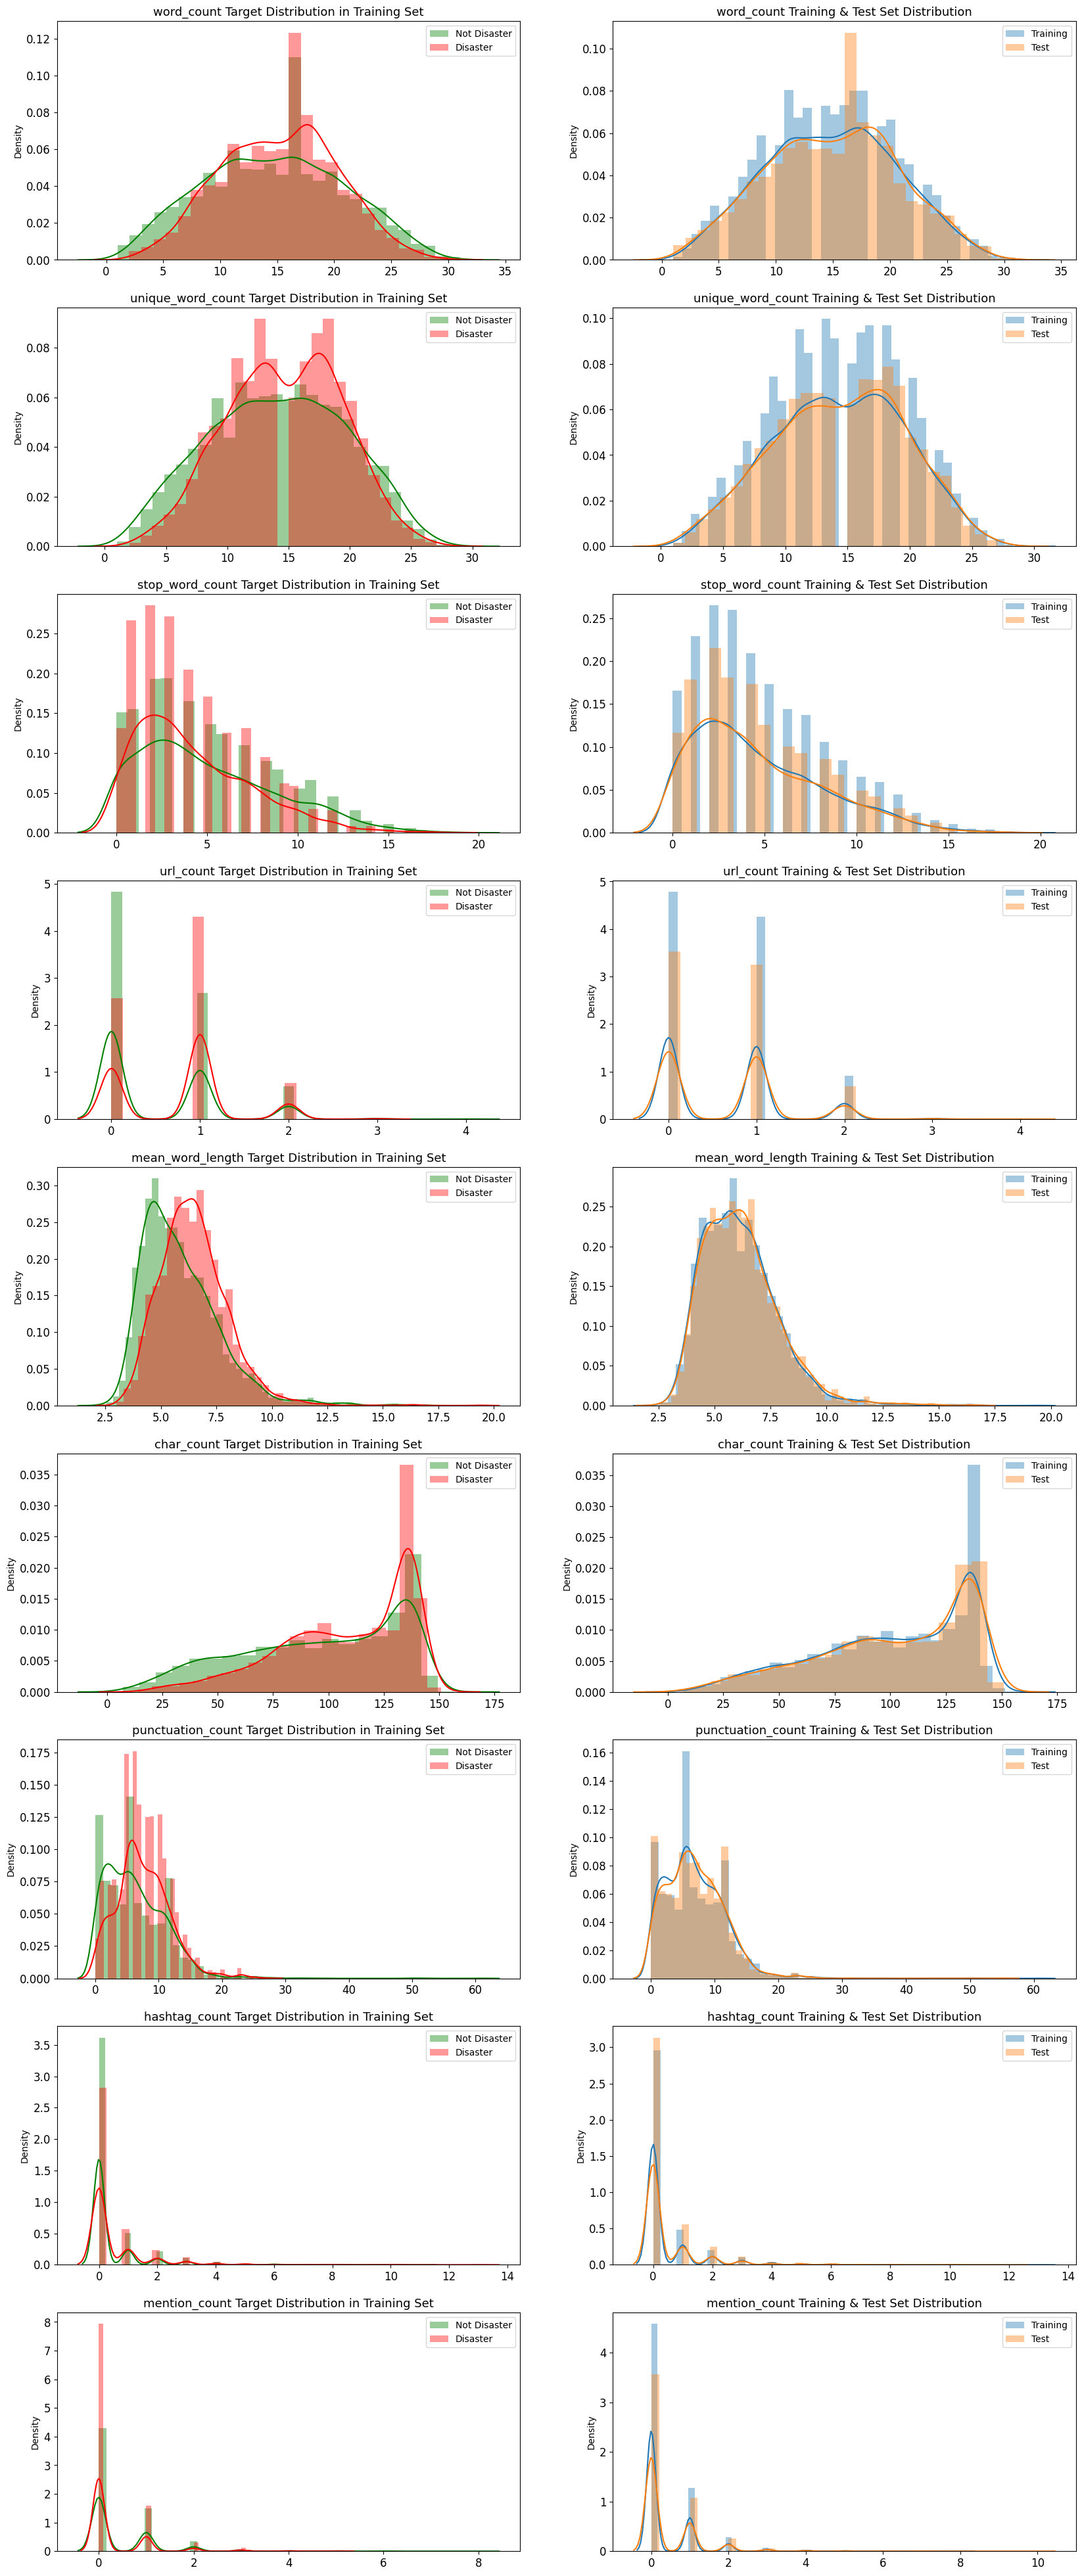

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# visualisation of meta features

METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = train_df['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_df.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train_df.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(train_df[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_df[feature], label='Test', ax=axes[i][1])

    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()

    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

In [ ]:
# understand the info of Ngrams

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in train_df[DISASTER_TWEETS]['text']: #　conditional on [DISASTER_TWEETS]
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1

for tweet in train_df[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1

df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in train_df[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1

for tweet in train_df[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1

df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in train_df[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1

for tweet in train_df[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1

df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

In [ ]:
df_disaster_unigrams

,0,1
0,-,389
1,fire,150
2,via,117
3,...,105
4,&amp;,105
...,...,...
14174,asked,1
14175,sask.,1
14176,ronge,1
14177,forgive,1


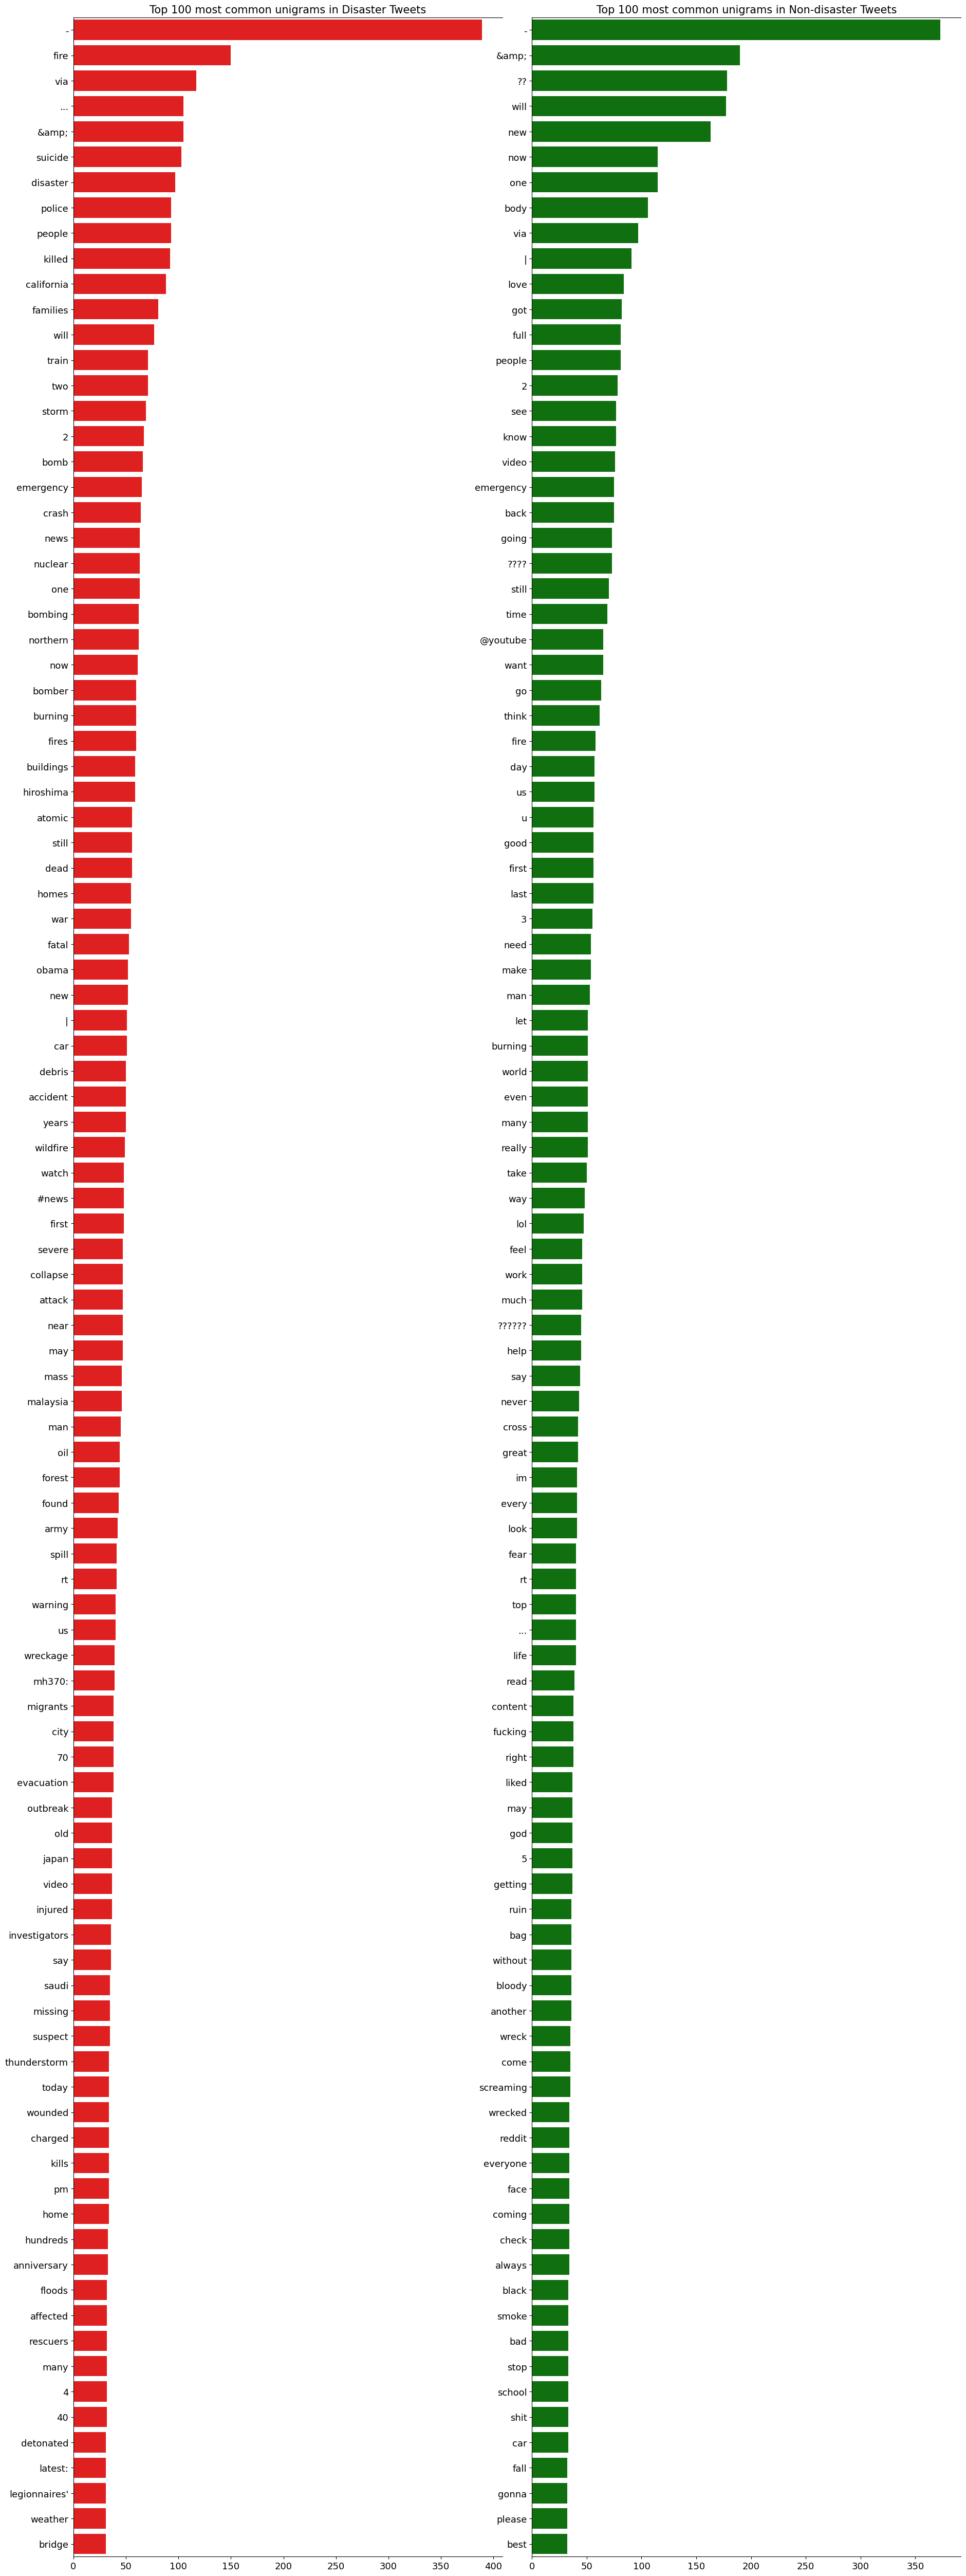

In [ ]:
# visualisation for Unigrams
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

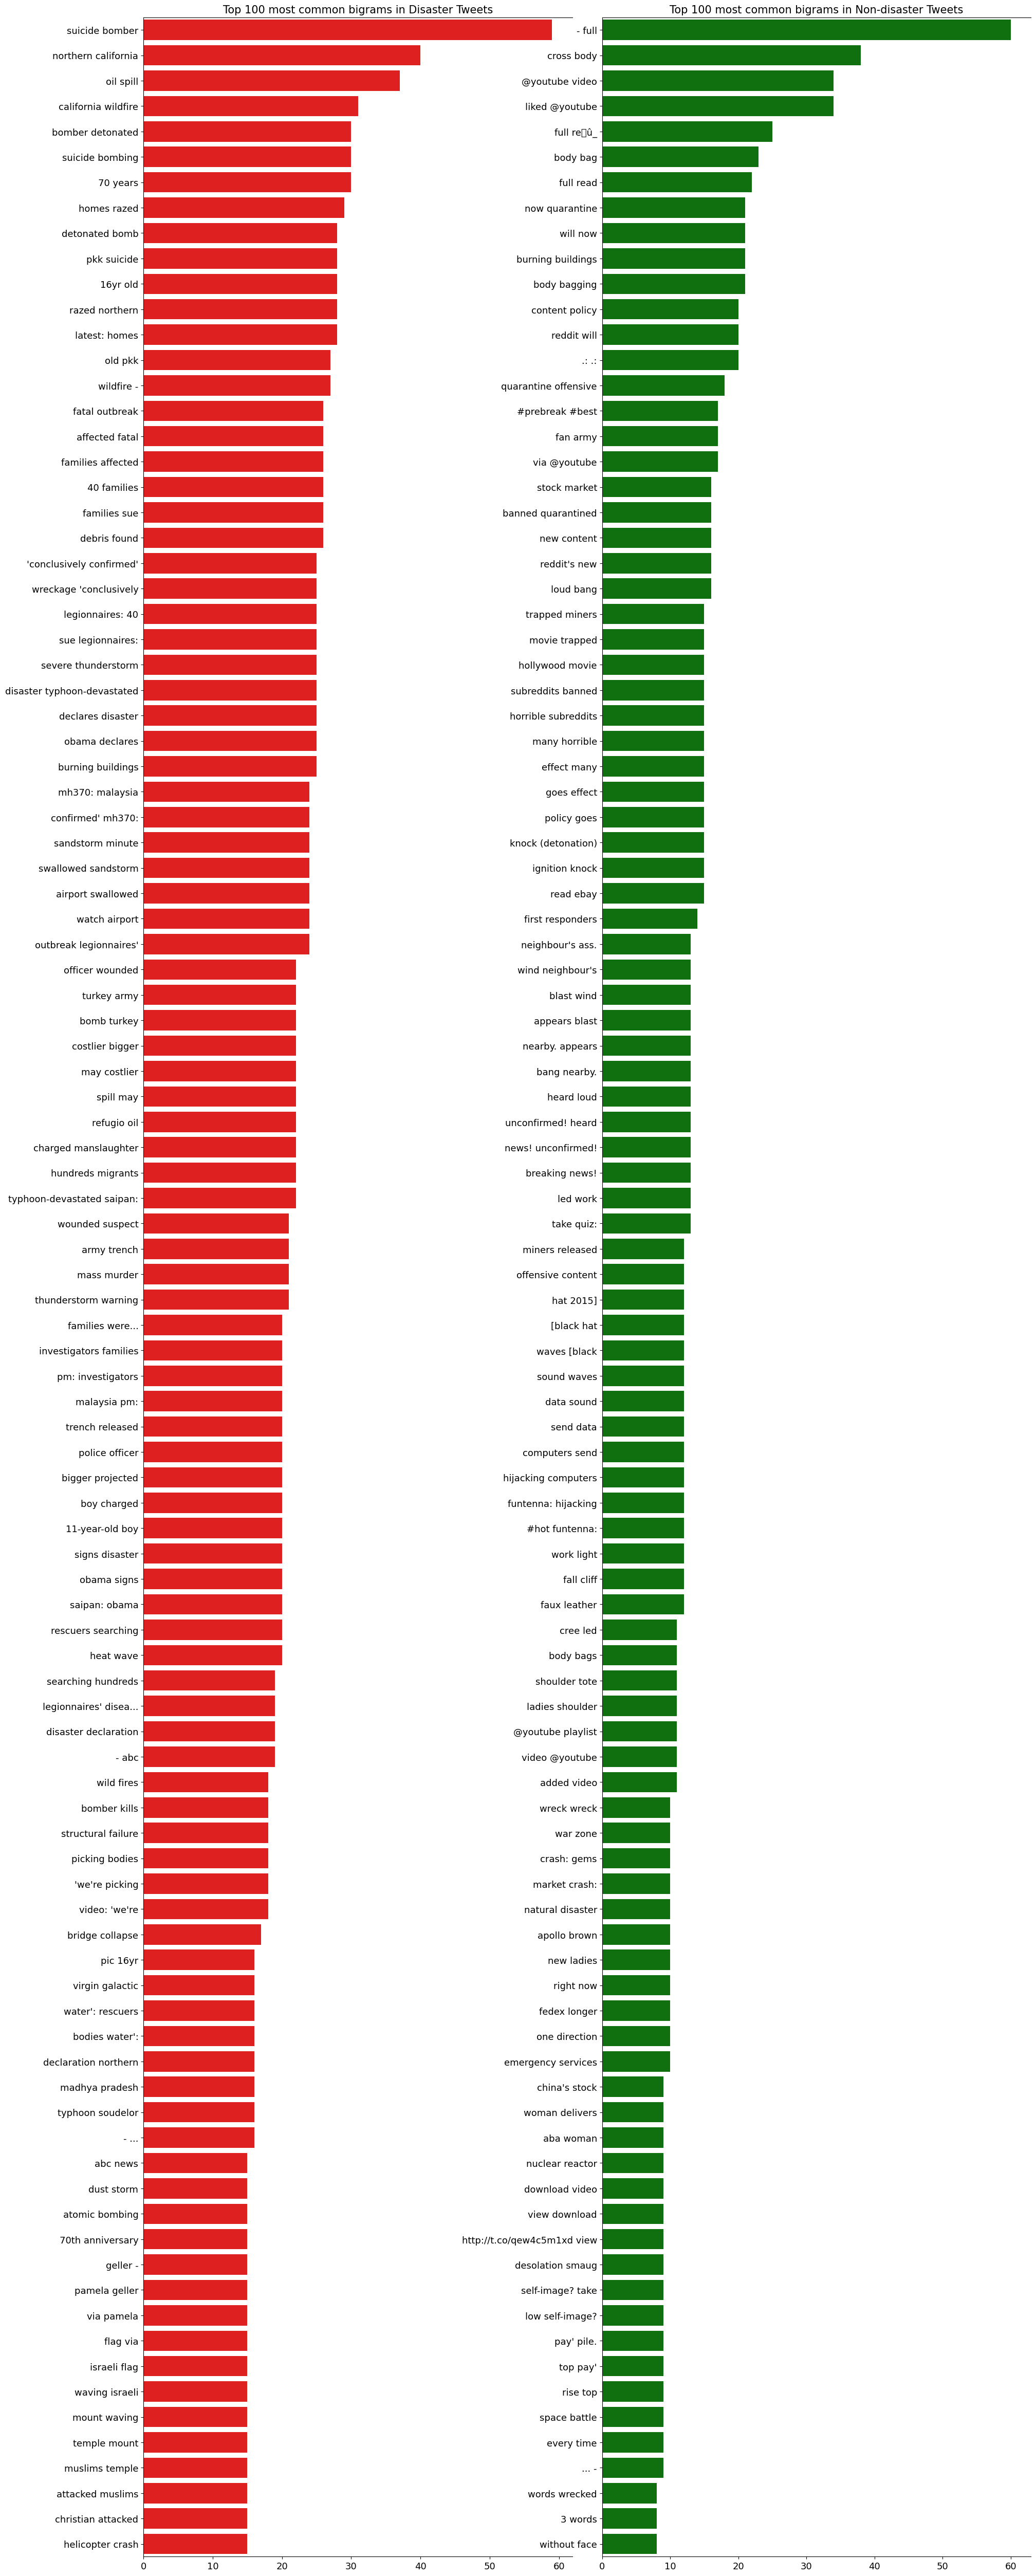

In [ ]:
# visualisation of bigrams
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

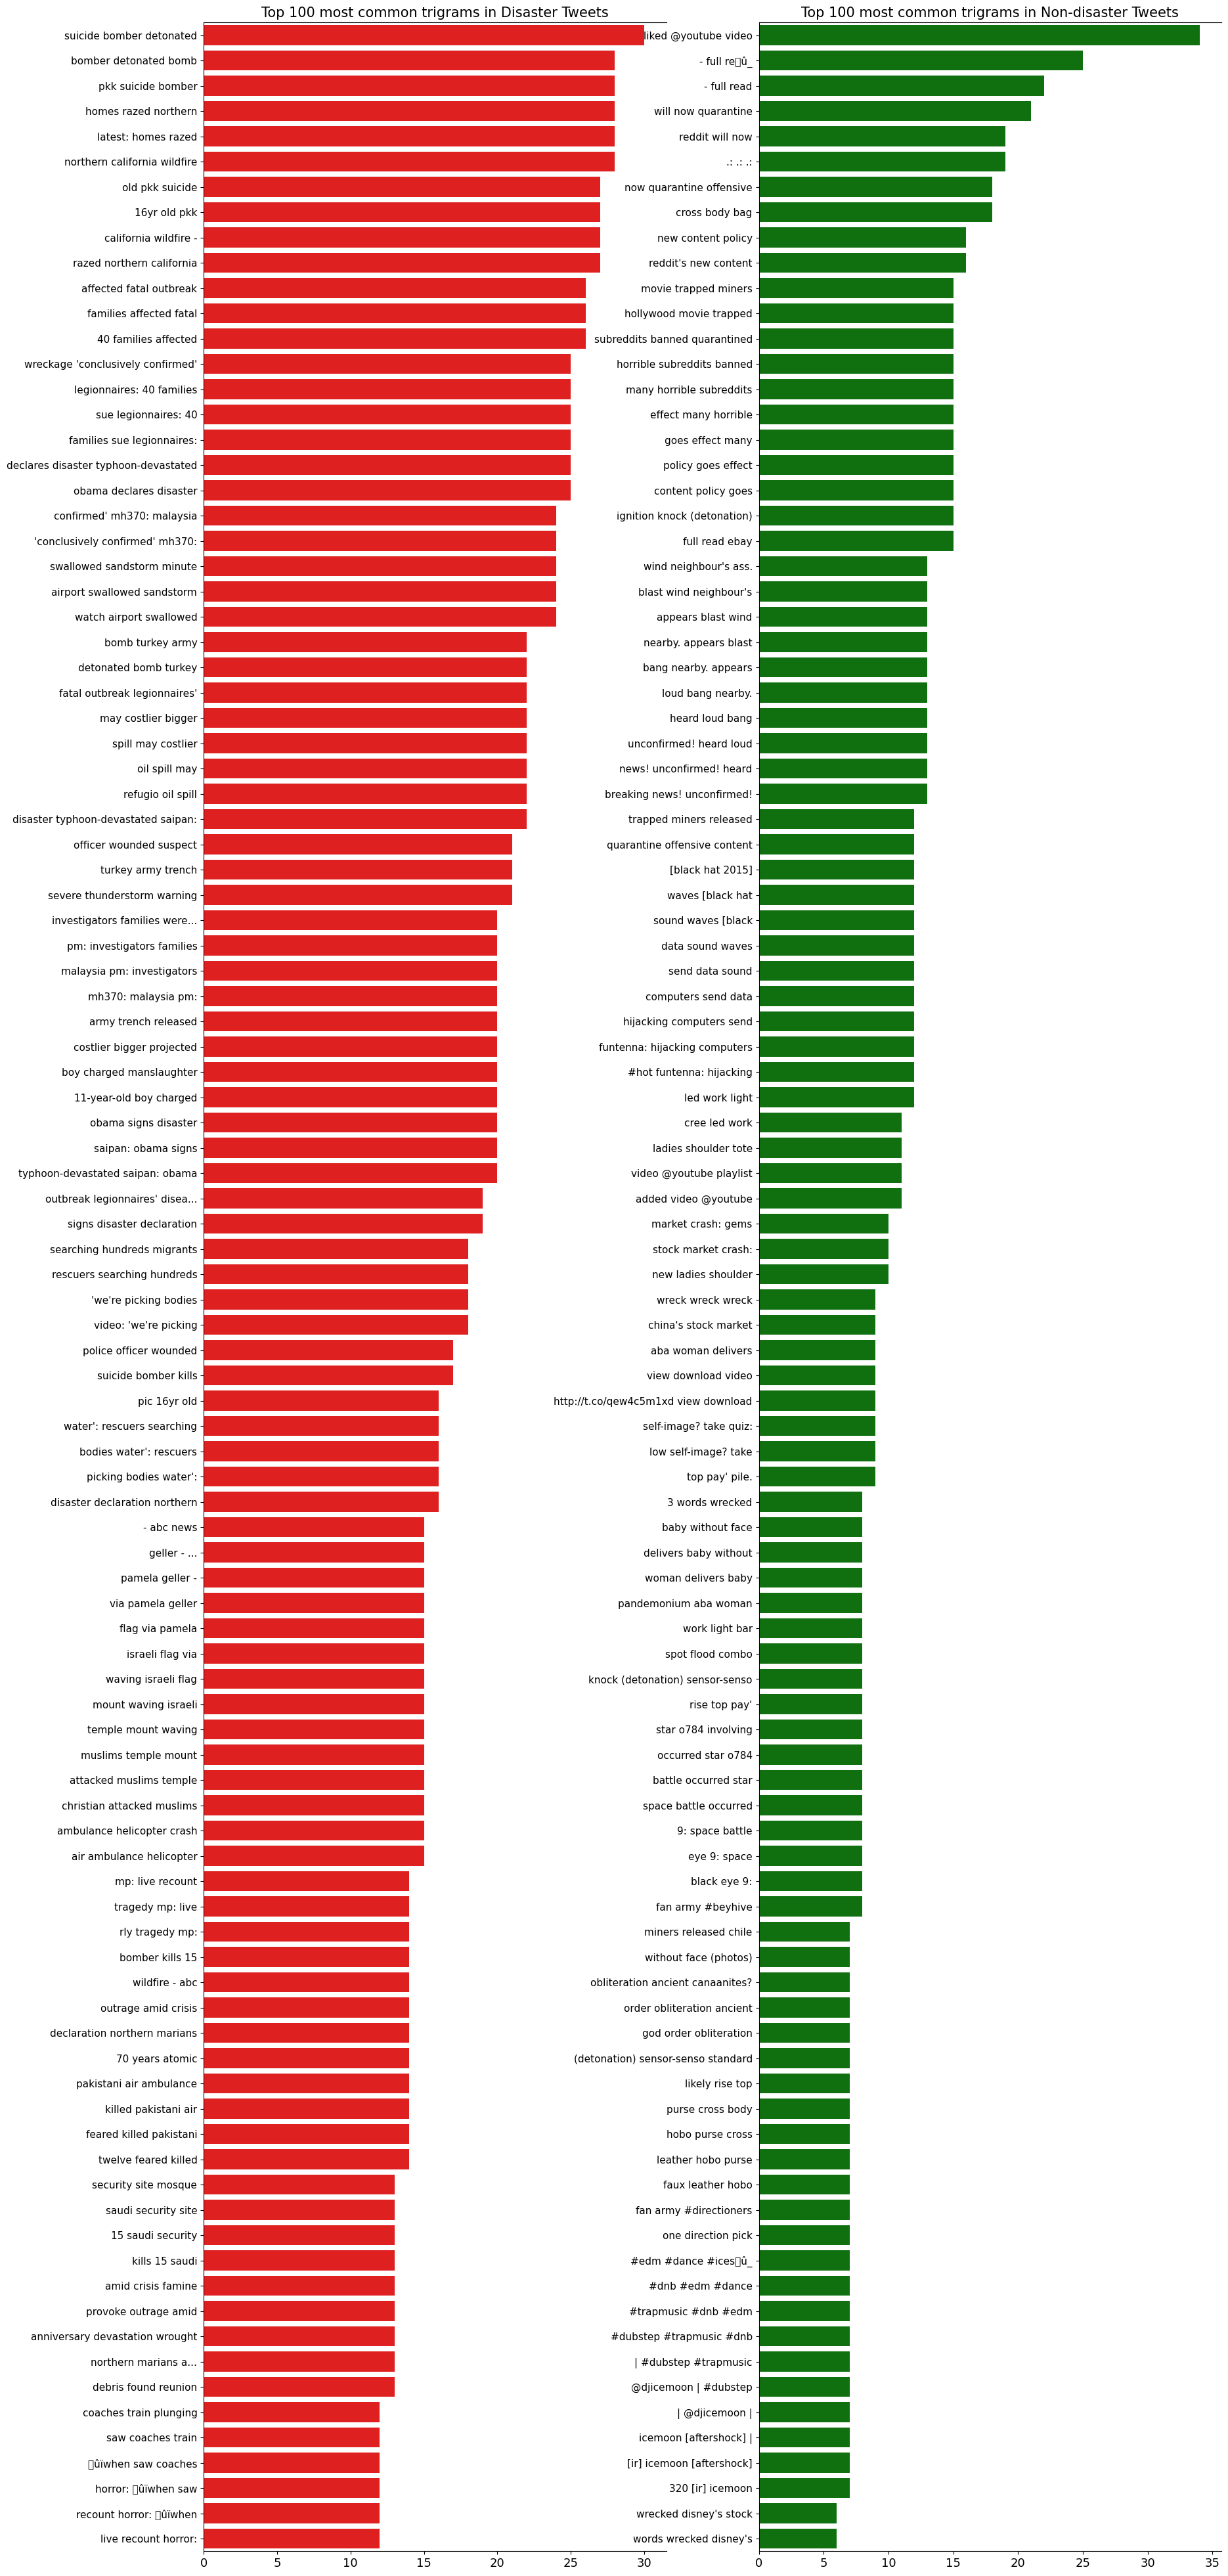

In [ ]:
# visualisation of trigrams
fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()

Here it is found that, in both Training and Test datasets:

1. The size of Training dataset is 7613, while the Test dataset is 3263

2. About the missing value:

    - 0.8% of keyword is missing in both training and test set

    - 33% of location is missing in both training and test set

    - Conclusion:

    - 1/3 of the location is missing, whild only 0.8% of the keyword is missing

    - Train and test dataset most probably taken from the same sample, the ratio of missing values in both are almost the same

3. The Cardinality：

    - Unique numbers of keywords in both training and test dataset are 222, and it is a small portion of the dataset

    - Unique numbers of Location is training dataset is: 3342, the test dataset is 1603, there are only 423 common unique location in both datasets

    - Conclusion:

    - Locations are not automatically generated, they are user inputs. That's why location is very dirty and there are too many unique values in it. It shouldn't be used as a feature.

    - Fortunately, there is signal in keyword because some of those words can only be used in one context. Keywords have very different tweet counts and target means. keyword can be used as a feature by itself or as a word added to the text. Every single keyword in training set exists in test set. If training and test set are from the same sample, it is also possible to use target encoding on keyword.
4. extract those with accumulated 2 target values
    - there are 18 rows of data with same text but classified as different targets
5. Class imbalance issue
    - Class distributions are 57% for 0 (Not Disaster) and 43% for 1 (Disaster). Classes are almost equally separated so they don't require any stratification by target in cross-validation.
6. Meta features
7. N-grams analysis
    - Most common unigrams exist in both classes are mostly punctuations, stop words or numbers. It is better to clean them before modelling since they don't give much information about target
    - Most common unigrams in disaster tweets are already giving information about disasters. It is very hard to use some of those words in other contexts.
    - Most common unigrams in non-disaster tweets are verbs. This makes sense because most of those sentences have informal active structure since they are coming from individual users.
    - There are no common bigrams exist in both classes because the context is clearer.
    - There are no common trigrams exist in both classes because the context is clearer.

## 4. Data processing

1. clean the text
2. handle Mislabeled Samples
3. handle missing value
4. Cross-validation of unique keyword


1. The data cleaning text are:

    * Removed urls, emojis, html tags and punctuations,

    * Tokenized the tweet base texts,

    * Lower cased clean text,

    * Removed stopwords,

    * Applied part of speech tags,

    * Converted part of speeches to wordnet format,

    * Applying word lemmatizer,

    * Converted tokenized text to string again.

load the Glove and Fasttext embedding into the dataset first

In [ ]:
#Load the 2 popular embedding
#glove
#fasttext

glove_embeddings = np.load('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', allow_pickle=True)
fasttext_embeddings = np.load('../input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl', allow_pickle=True)

MessageError: ignored

In [ ]:
# Embeddings Coverage

# break the tweet into words
def build_vocab(X):

    tweets = X.apply(lambda s: s.split()).values
    vocab = {}

    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab


def check_embeddings_coverage(X, embeddings):

    vocab = build_vocab(X)

    covered = {}
    oov = {}
    n_covered = 0
    n_oov = 0

    for word in vocab:
        try:
            covered[word] = embeddings[word] #函式嘗試將當前單詞加入到covered中，如果該單詞可以在embeddings中找到對應的向量
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word] # 否則，函式將當前單詞加入到oov中，表示該單詞未被涵蓋
            n_oov += vocab[word]

    #calculate the coverage
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))

    # 函式將oov字典按照值（即未涵蓋的單詞數量）進行排序，並以元祖列表的形式返回
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(train_df['text'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(test_df['text'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(train_df['text'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(test_df['text'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

GloVe Embeddings cover 52.06% of vocabulary and 82.68% of text in Training Set
GloVe Embeddings cover 57.21% of vocabulary and 81.85% of text in Test Set
FastText Embeddings cover 51.52% of vocabulary and 81.84% of text in Training Set
FastText Embeddings cover 56.55% of vocabulary and 81.12% of text in Test Set


In [ ]:
# read the oov and see how to further clean

# lump the 2 oov list as one
mergedlist = train_glove_oov + train_fasttext_oov

# 將新列表轉換為集合，這將刪除重複的元素
unique_set = set(mergedlist)

# 將集合轉換為列表，以便返回
total_oov = list(unique_set)
df_total_oov = pd.DataFrame(total_oov)

# save as new CSV
df_total_oov.to_csv('train_glove_oov.csv')

print(f"The counts of records in Glove OOV list is {len(train_glove_oov)}")
print(f"The counts of records in Fasttest OOV list is {len(train_fasttext_oov)}")
print(f"The counts of records in Total OOV list is {len(total_oov)}")

The counts of records in Glove OOV list is 15304
The counts of records in Fasttest OOV list is 15477
The counts of records in Total OOV list is 16170


Tweets require lots of cleaning but it is inefficient to clean every single tweet because that would consume too much time. A general approach must be implemented for cleaning.

1.     The most common type of words that require cleaning in oov have punctuations at the start or end. Those words doesn't have embeddings because of the trailing punctuations. Punctuations #, @, !, ?, +, &, -, $, =, <, >, |, {, }, ^, ', (, ),[, ], *, %, ..., ', ., :, ; are separated from words
2.     Special characters that are attached to words are removed completely
3.     Contractions are expanded
4.     Urls are removed
5.     Character entity references are replaced with their actual symbols
6.     Typos and slang are corrected, and informal abbreviations are written in their long forms
7.     Some words are replaced with their acronyms and some words are grouped into one
8.     Finally, hashtags and usernames contain lots of information about the context but they are written without spaces in between words so they don't have embeddings. Informational usernames and hashtags should be expanded but there are too many of them. I expanded as many as I could, but it takes too much time to run clean function after adding those replace calls.

In [ ]:
%%time

def clean(tweet):

    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)

    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)
    tweet = re.sub(r"donå«t", "do not", tweet)

    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)

    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)

    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet)
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
    tweet = re.sub(r"cnewslive", "C News Live", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"foodscare", "food scare", tweet)
    tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
    tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"po_st", "po.st", tweet)
    tweet = re.sub(r"scoopit", "scoop.it", tweet)
    tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
    tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet)
    tweet = re.sub(r"OutBid", "outbid", tweet)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
    tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
    tweet = re.sub(r"15PM", "15 PM", tweet)
    tweet = re.sub(r"OriginalFunko", "Funko", tweet)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
    tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
    tweet = re.sub(r"RT_America", "RT America", tweet)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
    tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
    tweet = re.sub(r"gunsense", "gun sense", tweet)
    tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet)
    tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
    tweet = re.sub(r"Japton", "Arkansas", tweet)
    tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
    tweet = re.sub(r"versethe", "verse the", tweet)
    tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
    tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
    tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
    tweet = re.sub(r"NANKANA", "Nankana", tweet)
    tweet = re.sub(r"SAHIB", "Sahib", tweet)
    tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
    tweet = re.sub(r"gofundme", "go fund me", tweet)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
    tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
    tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
    tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
    tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
    tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
    tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"IndianNews", "Indian News", tweet)
    tweet = re.sub(r"savebees", "save bees", tweet)
    tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"s2g", "swear to god", tweet)
    tweet = re.sub(r"listenlive", "listen live", tweet)
    tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
    tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
    tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
    tweet = re.sub(r"HORNDALE", "Horndale", tweet)
    tweet = re.sub(r"PINER", "Piner", tweet)
    tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
    tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
    tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
    tweet = re.sub(r"pop2015", "pop 2015", tweet)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
    tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
    tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
    tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
    tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
    tweet = re.sub(r"UNHEALED", "unhealed", tweet)
    tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
    tweet = re.sub(r"Latestnews", "Latest news", tweet)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
    tweet = re.sub(r"datingtips", "dating tips", tweet)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"hempoil", "hemp oil", tweet)
    tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet)
    tweet = re.sub(r"tubestrike", "tube strike", tweet)
    tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
    tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet)
    tweet = re.sub(r"TI5", "The International 5", tweet)
    tweet = re.sub(r"thehill", "the hill", tweet)
    tweet = re.sub(r"3others", "3 others", tweet)
    tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
    tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet)
    tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet)
    tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet)
    tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
    tweet = re.sub(r"offdishduty", "off dish duty", tweet)
    tweet = re.sub(r"andword", "and word", tweet)
    tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
    tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"57am", "57 am", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet)
    tweet = re.sub(r"newnewnew", "new new new", tweet)
    tweet = re.sub(r"under50", "under 50", tweet)
    tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
    tweet = re.sub(r"amwriting", "am writing", tweet)
    tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
    tweet = re.sub(r"Nowlike", "Now like", tweet)
    tweet = re.sub(r"seasonfrom", "season from", tweet)
    tweet = re.sub(r"epicente", "epicenter", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"sicklife", "sick life", tweet)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
    tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
    tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
    tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet)
    tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet)
    tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet)
    tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
    tweet = re.sub(r"newauthors", "new authors", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"44PM", "44 PM", tweet)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
    tweet = re.sub(r"40PM", "40 PM", tweet)
    tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
    tweet = re.sub(r"ithats", "that is", tweet)
    tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet)
    tweet = re.sub(r"FatLoss", "Fat Loss", tweet)
    tweet = re.sub(r"02PM", "02 PM", tweet)
    tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
    tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
    tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet)
    tweet = re.sub(r"GeorgeTakei", "George Takei", tweet)
    tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
    tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
    tweet = re.sub(r"incubusband", "incubus band", tweet)
    tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
    tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
    tweet = re.sub(r"win10", "Windows 10", tweet)
    tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
    tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet)
    tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
    tweet = re.sub(r"crewlist", "crew list", tweet)
    tweet = re.sub(r"Erdogans", "Erdogan", tweet)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet)
    tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
    tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
    tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
    tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
    tweet = re.sub(r"pctool", "pc tool", tweet)
    tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet)
    tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet)
    tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
    tweet = re.sub(r"LakeEffect", "Lake Effect", tweet)
    tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
    tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
    tweet = re.sub(r"writerslife", "writers life", tweet)
    tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
    tweet = re.sub(r"UnusualWords", "Unusual Words", tweet)
    tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
    tweet = re.sub(r"acreativedc", "a creative DC", tweet)
    tweet = re.sub(r"vscodc", "vsco DC", tweet)
    tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
    tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
    tweet = re.sub(r"buildingmuseum", "building museum", tweet)
    tweet = re.sub(r"WorldOil", "World Oil", tweet)
    tweet = re.sub(r"redwedding", "red wedding", tweet)
    tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet)
    tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet)
    tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
    tweet = re.sub(r"bleased", "blessed", tweet)
    tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
    tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
    tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
    tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
    tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet)
    tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
    tweet = re.sub(r"changetheworld", "change the world", tweet)
    tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
    tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
    tweet = re.sub(r"withweapons", "with weapons", tweet)
    tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
    tweet = re.sub(r"letsFootball", "let us Football", tweet)
    tweet = re.sub(r"LateNiteMix", "late night mix", tweet)
    tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
    tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet)
    tweet = re.sub(r"22PM", "22 PM", tweet)
    tweet = re.sub(r"54am", "54 AM", tweet)
    tweet = re.sub(r"38am", "38 AM", tweet)
    tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet)
    tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet)
    tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
    tweet = re.sub(r"2k15", "2015", tweet)
    tweet = re.sub(r"TheIran", "Iran", tweet)
    tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet)
    tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet)
    tweet = re.sub(r"defense_news", "defense news", tweet)
    tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet)
    tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
    tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
    tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet)
    tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet)
    tweet = re.sub(r"toopainful", "too painful", tweet)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
    tweet = re.sub(r"NoNukes", "No Nukes", tweet)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
    tweet = re.sub(r"ineedcake", "I need cake", tweet)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
    tweet = re.sub(r"BBCOne", "BBC One", tweet)
    tweet = re.sub(r"AlexxPage", "Alex Page", tweet)
    tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
    tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet)
    tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
    tweet = re.sub(r"irongiant", "iron giant", tweet)
    tweet = re.sub(r"RonFunches", "Ron Funches", tweet)
    tweet = re.sub(r"TimCook", "Tim Cook", tweet)
    tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
    tweet = re.sub(r"Madsummer", "Mad summer", tweet)
    tweet = re.sub(r"NowYouKnow", "Now you know", tweet)
    tweet = re.sub(r"concertphotography", "concert photography", tweet)
    tweet = re.sub(r"TomLandry", "Tom Landry", tweet)
    tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
    tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
    tweet = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", tweet)
    tweet = re.sub(r"FromTheDesk", "From The Desk", tweet)
    tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
    tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet)
    tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet)
    tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
    tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
    tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet)
    tweet = re.sub(r"NotSorry", "not sorry", tweet)
    tweet = re.sub(r"UseYourWords", "use your words", tweet)
    tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
    tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
    tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
    tweet = re.sub(r"jokethey", "joke they", tweet)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
    tweet = re.sub(r"uiseful", "useful", tweet)
    tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet)
    tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
    tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet)
    tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet)
    tweet = re.sub(r"birdgang", "bird gang", tweet)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
    tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
    tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
    tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
    tweet = re.sub(r"TOI_India", "The Times of India", tweet)
    tweet = re.sub(r"hegot", "he got", tweet)
    tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
    tweet = re.sub(r"sothathappened", "so that happened", tweet)
    tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
    tweet = re.sub(r"NationFirst", "Nation First", tweet)
    tweet = re.sub(r"IndiaToday", "India Today", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"BidTime", "Bid Time", tweet)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
    tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
    tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
    tweet = re.sub(r"eatshit", "eat shit", tweet)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
    tweet = re.sub(r"SahelNews", "Sahel News", tweet)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
    tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
    tweet = re.sub(r"facilitydude", "facility dude", tweet)
    tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
    tweet = re.sub(r"MarketResearch", "Market Research", tweet)
    tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
    tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
    tweet = re.sub(r"yychail", "Calgary hail", tweet)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
    tweet = re.sub(r"eliotschool", "eliot school", tweet)
    tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
    tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet)
    tweet = re.sub(r"RiverComplex", "River Complex", tweet)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
    tweet = re.sub(r"IranElection", "Iran Election", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"slownewsday", "slow news day", tweet)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
    tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet)
    tweet = re.sub(r"netbots", "net bots", tweet)
    tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
    tweet = re.sub(r"EndofUS", "End of United States", tweet)
    tweet = re.sub(r"35PM", "35 PM", tweet)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
    tweet = re.sub(r"76mins", "76 minutes", tweet)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
    tweet = re.sub(r"livesmatter", "lives matter", tweet)
    tweet = re.sub(r"myhometown", "my hometown", tweet)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
    tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
    tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
    tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
    tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
    tweet = re.sub(r"OculusRift", "Oculus Rift", tweet)
    tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
    tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
    tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
    tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
    tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"YEEESSSS", "yes", tweet)
    tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
    tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
    tweet = re.sub(r"NewsThousands", "News Thousands", tweet)
    tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet)
    tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet)
    tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
    tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet)
    tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet)
    tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
    tweet = re.sub(r"FromTheField", "From the field", tweet)
    tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
    tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
    tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet)
    tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
    tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
    tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet)
    tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
    tweet = re.sub(r"ServicesGold", "Services Gold", tweet)
    tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet)
    tweet = re.sub(r"Evaucation", "evacuation", tweet)
    tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
    tweet = re.sub(r"Tubestrike", "tube strike", tweet)
    tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
    tweet = re.sub(r"localplumber", "local plumber", tweet)
    tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
    tweet = re.sub(r"PayForItHow", "Pay for it how", tweet)
    tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
    tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
    tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet)
    tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
    tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
    tweet = re.sub(r"660NEWS", "660 NEWS", tweet)
    tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
    tweet = re.sub(r"wfocus", "focus", tweet)
    tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet)
    tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
    tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
    tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
    tweet = re.sub(r"NashNewVideo", "Nash new video", tweet)
    tweet = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", tweet)
    tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
    tweet = re.sub(r"bedhair", "bed hair", tweet)
    tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet)

    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)

    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')

    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')

    # Acronyms
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet)

    # Grouping same words without embeddings
    tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
    tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)

    return tweet

train_df['text_cleaned'] = train_df['text'].apply(lambda s : clean(s))
test_df['text_cleaned'] = test_df['text'].apply(lambda s : clean(s))

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(train_df['text_cleaned'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(test_df['text_cleaned'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(train_df['text_cleaned'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(test_df['text_cleaned'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

GloVe Embeddings cover 82.89% of vocabulary and 97.14% of text in Training Set
GloVe Embeddings cover 88.09% of vocabulary and 97.32% of text in Test Set
FastText Embeddings cover 82.88% of vocabulary and 97.12% of text in Training Set
FastText Embeddings cover 87.80% of vocabulary and 97.25% of text in Test Set
CPU times: user 7min 24s, sys: 223 ms, total: 7min 24s
Wall time: 7min 27s


In [ ]:
# After cleaning the tweets, glove_embeddings and fasttext_embeddings are deleted and garbage collected because they consume too much memory (10+ gigabytes).
del glove_embeddings, fasttext_embeddings, train_glove_oov, test_glove_oov, train_fasttext_oov, test_fasttext_oov
gc.collect()

146163

2. handle Mislabeled Samples

In [ ]:
# extract the list of "text"
df_mislabeled = train_df.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
df_mislabeled.index.tolist()

['like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit',
 'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!',
 "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!',
 'To fight bioterrorism sir.',
 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE',
 '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption',
 '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
 'He came to a land which was engulfed in tribal war and turned it into a land 

In [ ]:
# review and relabel the text one by one
train_df['target_relabeled'] = train_df['target'].copy()

train_df.loc[train_df['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 1
train_df.loc[train_df['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0

In [ ]:
train_df.shape

(7613, 16)

3. handle missing value

In [ ]:
# Missing values in those features are filled with no_keyword and no_location respectively.

for df in [train_df, test_df]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

4. Cross-validation of unique keyword

In [ ]:
# Scikit-learn庫中的StratifiedKFold類別，它可以將資料集分為K個互斥的子集，以便進行交叉驗證
# 為了確保每個子集都能夠代表整個資料集的類別分佈
K = 3
skf = StratifiedKFold(n_splits=K, random_state=SEED, shuffle=True)

DISASTER = train_df['target'] == 1
print('Whole Training Set Shape = {}'.format(train_df.shape))
print('Whole Training Set Unique keyword Count = {}'.format(train_df['keyword'].nunique()))
print('Whole Training Set Target Rate (Disaster) {}/{} (Not Disaster)'.format(train_df[DISASTER]['target_relabeled'].count(), train_df[~DISASTER]['target_relabeled'].count()))

#在每個子集的迭代中，程式碼選擇訓練集和驗證集中文本數據的子集，然後使用shape屬性顯示它們的形狀。這將顯示訓練集中有多少行和列，以及驗證集中有多少行和列
# 接下來，計算訓練集和驗證集中關鍵字的唯一數量, 了解訓練集和驗證集之間的關鍵字分佈是否相似，進而確定模型是否過度擬合
# 每次迭代都會得到一個訓練集和一個驗證集的索引，這些索引可以用來從原始數據集中選擇相應的樣本進行訓練和驗證
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df['text_cleaned'], train_df['target']), 1):
    print('\nFold {} Training Set Shape = {} - Validation Set Shape = {}'.format(fold, train_df.loc[trn_idx, 'text_cleaned'].shape, train_df.loc[val_idx, 'text_cleaned'].shape))
    print('Fold {} Training Set Unique keyword Count = {} - Validation Set Unique keyword Count = {}'.format(fold, train_df.loc[trn_idx, 'keyword'].nunique(), train_df.loc[val_idx, 'keyword'].nunique()))

Whole Training Set Shape = (7613, 16)
Whole Training Set Unique keyword Count = 222
Whole Training Set Target Rate (Disaster) 3271/4342 (Not Disaster)

Fold 1 Training Set Shape = (5075,) - Validation Set Shape = (2538,)
Fold 1 Training Set Unique keyword Count = 222 - Validation Set Unique keyword Count = 222

Fold 2 Training Set Shape = (5075,) - Validation Set Shape = (2538,)
Fold 2 Training Set Unique keyword Count = 222 - Validation Set Unique keyword Count = 222

Fold 3 Training Set Shape = (5076,) - Validation Set Shape = (2537,)
Fold 3 Training Set Unique keyword Count = 222 - Validation Set Unique keyword Count = 222


## 5. Model

Metric

*     Accuracy measures the fraction of the total sample that is correctly identified
*     Precision measures that out of all the examples predicted as positive, how many are actually positive
*     Recall measures that out of all the actual positives, how many examples were correctly classified as positive by the model
*     F1 Score is the harmonic mean of the Precision and Recall

#### Model options

1. BERT model
2. Word2Vec
3. GloVe
4. ELMo
5. GPT（Generative Pre-trained Transformer）

In [ ]:
# track the accuracy performance of a binary classification model during training and validation

class ClassificationReport(Callback):

    def __init__(self, train_data=(), validation_data=()):
        super(Callback, self).__init__()

        self.X_train, self.y_train = train_data # tuples containing the input data and labels for the training and validation sets, respectively
        self.train_precision_scores = [] # empty list
        self.train_recall_scores = []
        self.train_f1_scores = []

        self.X_val, self.y_val = validation_data
        self.val_precision_scores = []
        self.val_recall_scores = []
        self.val_f1_scores = []

    def on_epoch_end(self, epoch, logs={}): # Keras回調函數的on_epoch_end方法
        train_predictions = np.round(self.model.predict(self.X_train, verbose=0)) # rounding the output
        train_precision = precision_score(self.y_train, train_predictions, average='macro') # functions from the sklearn.metrics module
        train_recall = recall_score(self.y_train, train_predictions, average='macro') # The average parameter is set to 'macro', which means that the scores are calculated for each class and then averaged.
        train_f1 = f1_score(self.y_train, train_predictions, average='macro')
        self.train_precision_scores.append(train_precision) # appended to the corresponding lists
        self.train_recall_scores.append(train_recall)
        self.train_f1_scores.append(train_f1)

        val_predictions = np.round(self.model.predict(self.X_val, verbose=0))
        val_precision = precision_score(self.y_val, val_predictions, average='macro')
        val_recall = recall_score(self.y_val, val_predictions, average='macro')
        val_f1 = f1_score(self.y_val, val_predictions, average='macro')
        self.val_precision_scores.append(val_precision)
        self.val_recall_scores.append(val_recall)
        self.val_f1_scores.append(val_f1)

        print('\nEpoch: {} - Training Precision: {:.6} - Training Recall: {:.6} - Training F1: {:.6}'.format(epoch + 1, train_precision, train_recall, train_f1)) # maximum of 6 decimal places
        print('Epoch: {} - Validation Precision: {:.6} - Validation Recall: {:.6} - Validation F1: {:.6}'.format(epoch + 1, val_precision, val_recall, val_f1))

1. BERT（Bidirectional Encoder Representations from Transformers）
    - 是一種自然語言處理中的深度學習模型，它是由Google在2018年推出的。
    - BERT基於Transformer架構，通過預訓練和微調的方式，實現了在多項自然語言處理任務上的高效表現。
    - TensorFlow的核心是計算圖（Computation Graph）
    - 指明是否可以被訓練（即在反向傳播過程中更新權重）


Other size BERT model
https://tfhub.dev/google/collections/bert/1

In [ ]:
%%time

# BERT from the TensorFlow Models repository on GitHub
# uses L=12 hidden layers (Transformer blocks), a hidden size of H=768, and A=12 attention heads
# This model has been pre-trained for English on the Wikipedia and BooksCorpus
# Inputs have been "uncased"
# 隱藏層數（L）：BERT 模型使用了 12 個 Transformer 塊（blocks），每個塊包含一個多頭自注意力機制（Multi-Head Self-Attention）和一個前向神經網絡（Feed-Forward Network）。
    # 這些 Transformer 塊可以將輸入序列進行多次非線性轉換和提取特徵，從而生成較高層次的語言表示。
# 隱藏維度（H）：BERT 模型的每個隱藏層包含 768 個神經元，稱為隱藏維度。這個參數決定了模型學習的特徵空間的維度大小，也影響了模型的複雜度和計算效率。
# 注意力頭數（A）：BERT 模型中的注意力機制包含 12 個注意力頭，每個頭學習一個不同的注意力權重，從而能夠捕捉不同的語言關係。注意力頭數的增加可以提高模型的表示能力和精度，但同時也會增加計算成本和內存消耗。

bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)
# 指定了這個 layer 是否可以被訓練（即在反向傳播過程中更新權重）

CPU times: user 10.8 s, sys: 1.25 s, total: 12 s
Wall time: 13.9 s


In [ ]:
# preserve_unused_tokens=False

import sys #  sys 模塊
from absl import flags # flags 函數庫
sys.argv=['preserve_unused_tokens=False'] # 這行程式碼是將 preserve_unused_tokens=False 設定為 sys.argv 的值
flags.FLAGS(sys.argv)

['preserve_unused_tokens=False']

In [ ]:
# DisasterDetector is a wrapper that incorporates the cross-validation and metrics stated above
class DisasterDetector:

    def __init__(self, bert_layer, max_seq_length=128, lr=0.0001, epochs=15, batch_size=32):
        # batch_size=32表示每次模型訓練時會使用32個樣本進行訓練
        # epochs是指訓練過程中的迭代次數，每個epoch表示模型已經遍歷了一次整個訓練數據集

        # BERT and Tokenization params
        self.bert_layer = bert_layer
        # 使用了 hub.KerasLayer() 方法將 BERT 模型封裝成 Keras layer
        # 將一個完整的深度學習模型轉換為一個可以嵌入到其他模型中的layer

        self.max_seq_length = max_seq_length
        vocab_file = self.bert_layer.resolved_object.vocab_file.asset_path.numpy() #vocab file - embeddings
        do_lower_case = self.bert_layer.resolved_object.do_lower_case.numpy() # convert to uncased
        self.tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

        # Learning control params
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size

        self.models = []
        self.scores = {}


    # 將文本資料轉換為BERT模型所需的三個輸入：token ID 列表、mask 列表和segment ID 列表
    def encode(self, texts):

        all_tokens = []
        all_masks = []
        all_segments = []

        for text in texts:
            text = self.tokenizer.tokenize(text) #將其轉換為 BERT token 列表
            text = text[:self.max_seq_length - 2] # 將 token 列表截斷到指定的最大序列長度
            input_sequence = ['[CLS]'] + text + ['[SEP]'] #並在序列的開頭和末尾添加特殊標記 [CLS] 和 [SEP]，用來區分序列的開始和結束位置。
            pad_len = self.max_seq_length - len(input_sequence) #计算填充长度 pad_len

            tokens = self.tokenizer.convert_tokens_to_ids(input_sequence) #token 序列轉換為對應的 token ID 列表
            tokens += [0] * pad_len #在 token ID 列表的末尾添加 pad_len 个 0 值，使得序列长度达到最大序列长度
            pad_masks = [1] * len(input_sequence) + [0] * pad_len #前面是 input_sequence 的实际长度个 1，后面是 pad_len 个 0，达到最大序列长度
            segment_ids = [0] * self.max_seq_length # 因為這裡只處理單個文本序列，所以长度为最大序列长度，其中所有元素都为 0（因为这里只处理单个文本序列）

            #segment id 列表是用來區分兩個句子的序列的。它主要用於處理兩個句子之間的關係，例如進行句子對分類、句子關聯性分析等任務。

            # 將文本資料轉換為BERT模型所需的三個輸入
            all_tokens.append(tokens)
            all_masks.append(pad_masks)
            all_segments.append(segment_ids)

        return np.array(all_tokens), np.array(all_masks), np.array(all_segments)


    def build_model(self):
        # 定義三個輸入層，分別為 input_word_ids、input_mask 和 segment_ids，用來接收文本資料轉換為BERT模型所需的三個輸入：token ID 列表、mask 列表和segment ID 列表。

        input_word_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_word_ids') # 代表一個序列中的單詞編號
        input_mask = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_mask') # 代表哪些位置是padding, 用於指示哪些單詞是真正的單詞，哪些是填充（padding）的。
        segment_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='segment_ids') # 代表句子分割的位置

        # 獲得兩個輸出：pooled_output 和 sequence_output。
        # 對於每個輸入token，BERT模型都會輸出一個對應的隱藏狀態向量
        pooled_output, sequence_output = self.bert_layer([input_word_ids, input_mask, segment_ids])
        clf_output = sequence_output[:, 0, :] # 第一個冒號表示選取所有的序列，第二個冒號表示選取序列中的第一個元素，最後一個冒號表示選取所有的特徵向量
        out = Dense(1, activation='sigmoid')(clf_output)# Dense 層將對這個輸出進行線性變換，將其轉換為一個具有固定維度的向量，
        # 然後通過 sigmoid 函數進行激活，將輸出值限制在 [0, 1] 的範圍內，表示二元分類的概率

        model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out) # 將輸入層和輸出層傳遞給 Model 類建立模型
        optimizer = SGD(learning_rate=self.lr, momentum=0.8) # 隨機梯度下降（SGD）優化器 optimizer 進行編譯
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) # 損失函數為交叉熵損失函數 binary_crossentropy，評估指標為準確度 accuracy
        # model.compile()方法是Keras中用於編譯模型的方法
        # loss：用於衡量模型在訓練過程中的損失函數。損失函數通常是一個數學函數，用於計算模型預測值和真實值之間的差距
        # optimizer： 用於訓練模型的優化器，例如Adam、SGD等。優化器通常用於調整模型的參數（權重和偏置），使得模型的預測結果盡可能貼近真實值
        # metric: metrics：用於評估模型性能的指標，例如精確度（accuracy）、召回率（recall）、F1值等. 可以設置一個或多個評估指標
        # 使用model.compile()方法後, Keras會計算訓練損失和評估指標，並且使用優化器來更新模型的權重和偏置



        return model


    def train(self, X):
        # X是一個包含文本數據和標籤的數據框（DataFrame）
        # 訓練 BERT 模型並進行交叉驗證，以評估模型的性能
        # 重複K次上述步驟，計算K次交叉驗證的平均分數，用於評估模型的效果。
        # total 3 folds as defined above under "skf.split"
        for fold, (trn_idx, val_idx) in enumerate(skf.split(X['text_cleaned'], X['keyword'])): # 透過 skf.split 將資料切割成K個子集

            print('\nFold {}\n'.format(fold))

            X_trn_encoded = self.encode(X.loc[trn_idx, 'text_cleaned'].str.lower()) # 透過 self.encode 將訓練集和驗證集的文本資料轉換為Bert模型的輸入形式
            y_trn = X.loc[trn_idx, 'target_relabeled']
            X_val_encoded = self.encode(X.loc[val_idx, 'text_cleaned'].str.lower())
            y_val = X.loc[val_idx, 'target_relabeled']

            # Callbacks
            metrics = ClassificationReport(train_data=(X_trn_encoded, y_trn), validation_data=(X_val_encoded, y_val)) # 用於在每個訓練週期結束時計算模型的分類指標

            # Model
            model = self.build_model()
            model.fit(X_trn_encoded, y_trn, validation_data=(X_val_encoded, y_val), callbacks=[metrics], epochs=self.epochs, batch_size=self.batch_size) # 將 ClassificationReport 回調函數加入到 callbacks
            # epoch to be defined under the model
            # 在每個epoch結束時，模型將會對驗證集 (validation_data) 進行評估

            self.models.append(model) # 將訓練得到的模型保存到 models 列表中。
            self.scores[fold] = {
                'train': {
                    'precision': metrics.train_precision_scores,
                    'recall': metrics.train_recall_scores,
                    'f1': metrics.train_f1_scores
                },
                'validation': {
                    'precision': metrics.val_precision_scores,
                    'recall': metrics.val_recall_scores,
                    'f1': metrics.val_f1_scores
                }
            }


    def plot_learning_curve(self):

        fig, axes = plt.subplots(nrows=K, ncols=2, figsize=(20, K * 6), dpi=100)

        for i in range(K):

            # Classification Report curve
            # 使用 Seaborn 函式庫的 lineplot() 函式, 在左側的子圖上繪製驗證集的分類報告曲線, ，包括精度、召回率和 F1 分數
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[i].history.history['val_accuracy'], ax=axes[i][0], label='val_accuracy')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['precision'], ax=axes[i][0], label='val_precision')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['recall'], ax=axes[i][0], label='val_recall')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['f1'], ax=axes[i][0], label='val_f1')

            axes[i][0].legend()
            axes[i][0].set_title('Fold {} Validation Classification Report'.format(i), fontsize=14)

            # Loss curve
            # 在右側的子圖上繪製訓練集和驗證集的損失曲線
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[i].history.history['loss'], ax=axes[i][1], label='train_loss')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[i].history.history['val_loss'], ax=axes[i][1], label='val_loss')

            axes[i][1].legend()
            axes[i][1].set_title('Fold {} Train / Validation Loss'.format(i), fontsize=14)

            for j in range(2):
                axes[i][j].set_xlabel('Epoch', size=12)
                axes[i][j].tick_params(axis='x', labelsize=12)
                axes[i][j].tick_params(axis='y', labelsize=12)

        plt.show()


    def predict(self, X):

        X_test_encoded = self.encode(X['text_cleaned'].str.lower()) #self.encode 將測試數據轉換為Bert模型的輸入形式
        y_pred = np.zeros((X_test_encoded[0].shape[0], 1)) #建立一個形狀為 (X_test_encoded[0].shape[0], 1) 的0矩陣 y_pred，用於保存每個模型的預測結果。

        for model in self.models:
            y_pred += model.predict(X_test_encoded) / len(self.models) #將預測結果加總到 y_pred 矩陣中, 將 y_pred 矩陣除以模型的數量，得到平均預測值。

        return y_pred

## 6. Evaluation

In [ ]:
train_df.describe (include='all')

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,text_cleaned,target_relabeled
count,7613.000000,7613,7613,7613,7613.00000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613,7613.000000
unique,NaN,222,3342,7503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6985,NaN
top,NaN,no_keyword,no_location,11-Year-Old Boy Charged With Manslaughter of T...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Watch This Airport Get Swallowed Up By A Sands...,NaN
freq,NaN,61,2533,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966,14.903586,14.340733,4.672928,0.620255,6.128494,101.037436,6.839485,0.446999,0.362406,NaN,0.428084
std,3137.116090,NaN,NaN,NaN,0.49506,5.732604,5.277160,3.559228,0.664104,1.675464,33.781325,4.608758,1.099841,0.720097,NaN,0.494833
min,1.000000,NaN,NaN,NaN,0.00000,1.000000,1.000000,0.000000,0.000000,2.250000,7.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,2734.000000,NaN,NaN,NaN,0.00000,11.000000,11.000000,2.000000,0.000000,4.875000,78.000000,3.000000,0.000000,0.000000,NaN,0.000000
50%,5408.000000,NaN,NaN,NaN,0.00000,15.000000,14.000000,4.000000,1.000000,5.928571,107.000000,6.000000,0.000000,0.000000,NaN,0.000000
75%,8146.000000,NaN,NaN,NaN,1.00000,19.000000,18.000000,7.000000,1.000000,7.058824,133.000000,10.000000,0.000000,1.000000,NaN,1.000000


In [ ]:
clf = DisasterDetector(bert_layer, max_seq_length=128, lr=0.0001, epochs=5, batch_size=32)

clf.train(train_df)

# each fold got ard 5075-5076 data size
# 5075/32 (each batch) = 158.59 ~= 159
# therefore each epoch contained 159 batches


Fold 0

Epoch 1/5
159/159 [==============================] - ETA: 0s - loss: 0.4192 - accuracy: 0.8183
Epoch: 1 - Training Precision: 0.865318 - Training Recall: 0.843967 - Training F1: 0.85046
Epoch: 1 - Validation Precision: 0.853316 - Validation Recall: 0.833538 - Validation F1: 0.838875
159/159 [==============================] - 146s 831ms/step - loss: 0.4192 - accuracy: 0.8183 - val_loss: 0.3770 - val_accuracy: 0.8452
Epoch 2/5
159/159 [==============================] - ETA: 0s - loss: 0.3565 - accuracy: 0.8562
Epoch: 2 - Training Precision: 0.865712 - Training Recall: 0.852398 - Training F1: 0.857112
Epoch: 2 - Validation Precision: 0.845872 - Validation Recall: 0.83324 - Validation F1: 0.837233
159/159 [==============================] - 129s 811ms/step - loss: 0.3565 - accuracy: 0.8562 - val_loss: 0.3667 - val_accuracy: 0.8424
Epoch 3/5
159/159 [==============================] - ETA: 0s - loss: 0.3413 - accuracy: 0.8617
Epoch: 3 - Training Precision: 0.877663 - Training Recall:

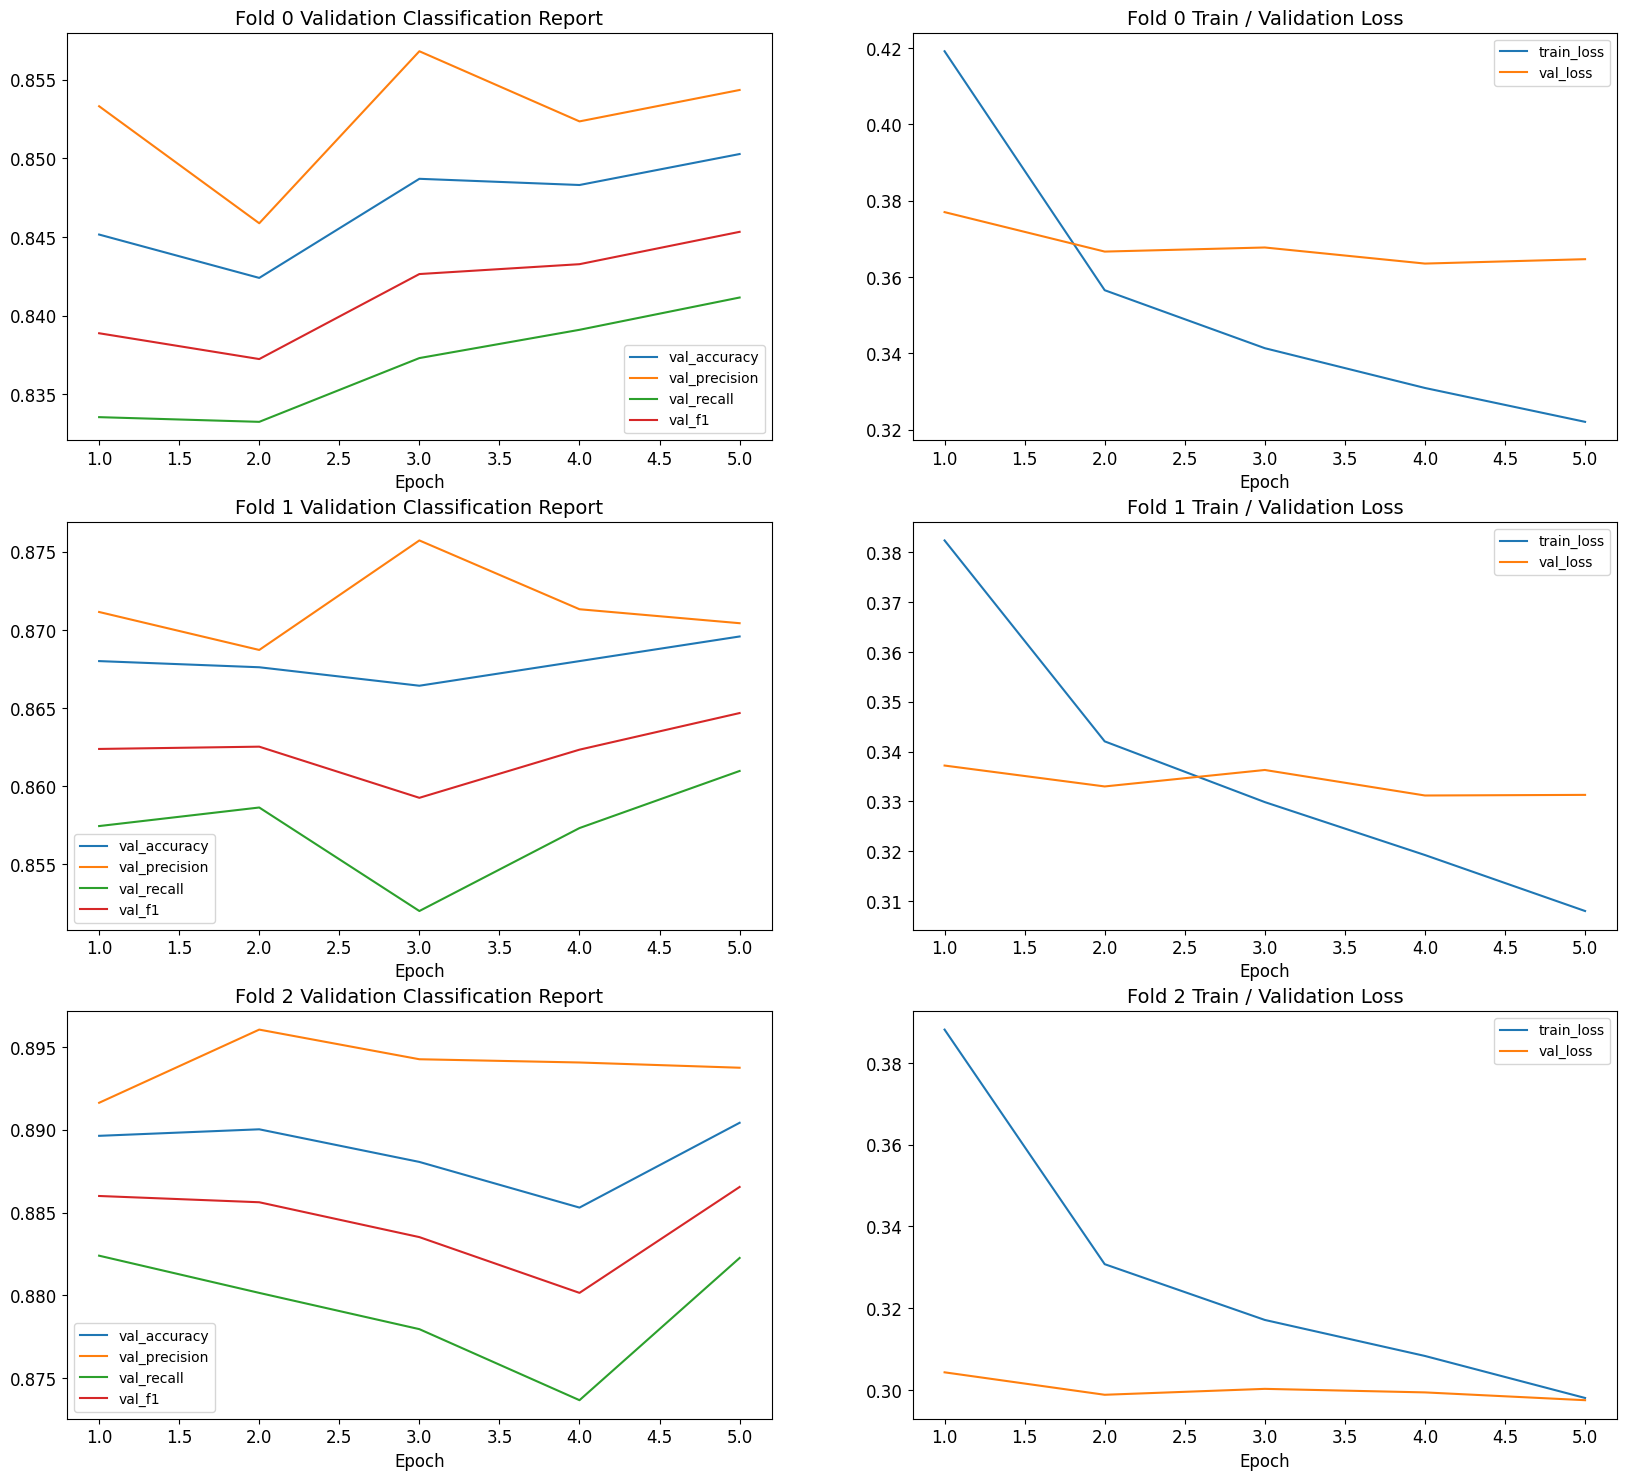

In [ ]:
clf.plot_learning_curve()

In [ ]:
# implementation
y_pred = clf.predict(test_df)

model_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
model_submission['target'] = np.round(y_pred).astype('int')
model_submission.to_csv('model_submission.csv', index=False)
model_submission.describe()

102/102 [==============================] - 16s 156ms/step


,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.403923
std,3146.427221,0.490758
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


Model options

2. Word2Vec
- 是一種基於神經網絡的詞向量表示模型，能夠將每個單詞映射到一個固定維度的向量空間中。Word2Vec 模型通過學習單詞的上下文信息，生成具有語義相似關係的詞向量
3. GloVe
- 基於全局向量（Global Vectors）的詞向量表示模型，能夠同時考慮單詞的上下文和全局統計信息。GloVe 模型通過最小化單詞共現矩陣的加權平方誤差，學習得到具有語義相似關係的詞向量
4. ELMo
- 基於深度雙向語言模型（Deep Bidirectional Language Model）的語言表示模型，能夠學習單詞的多層表示。ELMo 模型通過將單詞的不同層次的表示進行線性組合，生成具有上下文敏感性的詞向量
5. GPT（Generative Pre-trained Transformer）
- 基於 Transformer 模型的語言表示模型，與 BERT 模型類似，但是在訓練過程中只使用了掩碼語言模型任務。GPT 模型通過將前文的內容作為輸入，生成下一個詞的概率分布，從而構建了一個通用的語言模型。

PyTorch
 - 開源機器學習庫, 是一個開源的機器學習框架，由Facebook開發和維護。
 - PyTorch的核心是動態計算圖（Dynamic Computational Graph）& 靜態計算圖（Static Computational Graph）的支持
 - 使用PyTorch可以方便地構建和訓練各種語言表示模型，例如雙向循環神經網絡（Bidirectional Recurrent Neural Networks, BRNN）、Transformer模型、BERT等